<DIV ALIGN=CENTER>

# Introduction to Regularization
## Professor Robert J. Brunner
  
</DIV>  
-----
-----

## Introduction

In this notebook, we introduce the concept of regularization.
Regularization is a technique that is used to prevent [overfitting][wo]
when computing regression models. Overfitting describes the situation
when a model fits both the underlying signal and the noise in a data
set. This can occur when a model is overly complex, for example, when
it has too many parameters or coefficients when compared to the size of
the data set being modeled. The fundamental idea in regularization is to
add additional information in order to force a regression model to have
a specific behavior. For example, we can force the model coefficients
to preferentially take on smaller values, or we can force some (or most)
of the coefficients to become zero, thus effectively reducing the number
of model coefficients.

Below, we demonstrate these two types of regularization by
using the scikit learn library, and the same sample linear regression
data and code we used in earlier notebooks.

-----
[wo]: https://en.wikipedia.org/wiki/Overfitting

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white", font_scale=2.0)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

-----
### Data

Before exploring different techniques for modeling a data set, we first
need data to analyze. To focus on the process of regularization, we will
stick to the simple _simulated_ data set we created in the [Introduction
to Linear Regression][ilr] notebook.

Note that since we randomly generate our data, every time this Notebook
is run, we will get different results. Take advantage of this feature to
compare the different approaches as the underlying data change.

-----
[ilr]: ../../Week1/notebooks/intro2regress.ipynb

In [2]:
# We define a simple function to fit.

np.random.seed(0)

def theModel(xmin=0, xmax = 1, num=20):
    
    sigma = 0.1

    x = np.linspace(xmin, xmax, num)
    y = 0.25 + 0.5 * x - sigma * np.random.randn(len(x)) - sigma * x **2

    return(x, y)

----

### Polynomial Fitting

A simple first step is to see how different polynomial functions fit our
data. The scikit learn library allows us to compute a linear regression
by using a polynomial function. To simplify the process, we can use the
scikit learn library's pipeline feature to connect a polynomial fit to
the linear regression. Since we wish to compute different order
polynomial fits (to determine which one best approximates our data), we
place the pipeline creation, fitting, and scoring inside a loop.

As we increase the order of our polynomial fit, we allow moe flexibility
in our model to fit any intrinsic scatter (or variance) in our data.
While this can be a good thing, left unchecked we can reach a position
where our model _overfits_ the data. In this case, our model effectively
captures the signal and the noise, which is not what we desire. We can
demonstrate this issue by fitting a a number of polynomials of
different order to our simple data set and visualizing the tendency of
higher order polynomials to _capture the variance_.


-----

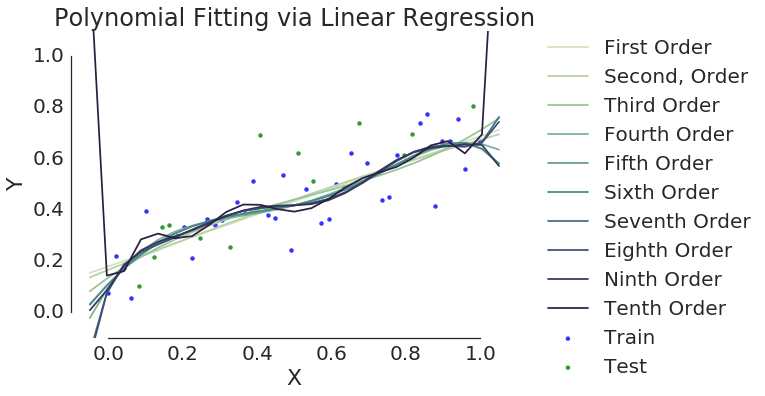

In [3]:
# Set the training fraction and maximum degree of polynomical fit
train_frac = 0.75
max_deg = 10
test_frac = 1.0 - train_frac

# Imports
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline as mp

from sklearn.cross_validation import train_test_split

# Make data
x, y = theModel(num = 50)

# Ready data set for cross-validation
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_frac)

# Start plot
ax = sns.regplot(x_train, y_train, fit_reg=False, color='b', label="Train")
ax = sns.regplot(x_test, y_test, fit_reg=False, color='g', label="Test")
cmp = sns.cubehelix_palette(max_deg, start=.5, rot=-.75)

lbls = ['First', 'Second,', 'Third', 'Fourth', 'Fifth', 'Sixth', 'Seventh', 'Eighth', 'Ninth', 'Tenth']

xf = np.linspace(-0.05,1.05,25)

for idx, deg in enumerate(range(1, max_deg + 1)):
    est = mp(PolynomialFeatures(deg), LinearRegression())
    est.fit(x_train[:, np.newaxis], y_train)

    plt.plot(xf, est.predict(xf[:, np.newaxis]), c=cmp[deg - 1], label='{0} Order'.format(lbls[idx]))
    
ax.set(title='Polynomial Fitting via Linear Regression',
       xlabel='X', xlim=(-0.1, 1.1),
       ylabel='Y', ylim=(-0.1, 1.1))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #loc=4)
sns.despine(offset=0, trim=True)

-----

Interestingly enough, all of the polynomials fit the data quite well in
the middle range, say 0.2-0.8. Outside these regions, however, the
higher order polynomials visually appear to fit the signal in the data
less well than the lower order polynomials. 



### Optimal Fitting

We can compute the MSE for each polynomial fit to determine which
polynomial best approximates our data. In this case, we see that, from
the **test** data, after a third or fourth order polynomial fit (in
general, the data is random and thus the results can vary) the accuracy
decreases.

In general, however, we don't (or can't) fit different polynomials and
compare the results. Thus, while this example is demonstrative of the
problem of overfitting and provides an explicit demonstration of the
optimal fitting function, we will want to explore more advanced
techniques.

----

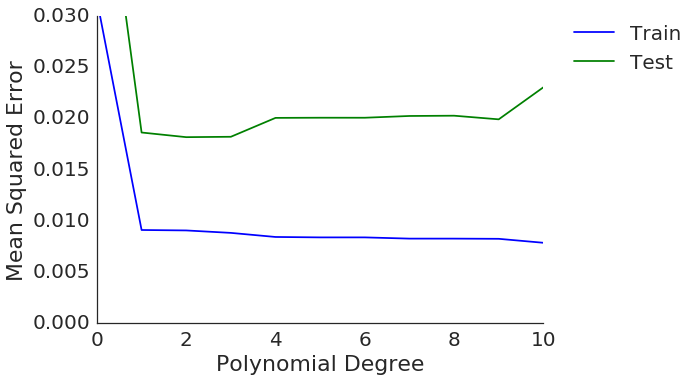

In [4]:
from sklearn.metrics import mean_squared_error as mse

# Initialize arrays
train_error = np.empty(max_deg + 1)
test_error = np.empty(max_deg + 1)

for deg in range(max_deg + 1):
    est = mp(PolynomialFeatures(deg), LinearRegression())
    est.fit(x_train[:, np.newaxis], y_train)
    train_error[deg] = mse(y_train, est.predict(x_train[:, np.newaxis]))
    test_error[deg] = mse(y_test, est.predict(x_test[:, np.newaxis]))

xp = np.arange(max_deg + 1)
plt.plot(xp, train_error, color='b', label='Train')
plt.plot(xp, test_error, color='g', label='Test')

plt.ylim((0.0, 0.03))

plt.ylabel('Mean Squared Error')
plt.xlabel('Polynomial Degree')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #loc=4)
sns.despine(offset=0, trim=True)

-----

### Ridge Regression

The first technique that we will demonstrate to reduce the likelihood of
overfitting is [ridge regression][rr], or Tikhonov regularization. Ridge
regression adds a penalty term, which is the L2 norm of the regression
coefficients, to the fitting process to emphasize _smooth_ fits rather
than _wildly fluctuating_ fits. In scikit learn, this technique is
encapsulated in the [`Ridge`][skr] class, and the L2 norm term is encoded by
the `alpha` parameter. 

In the following example, we demonstrate how to employ ridge regression
on our sample data set for a ninth order polynomial with different
values of `alpha`. After the code, the different coefficients for each
different value of the `alpha` parameter are displayed, along with the
different fits. From this example, you should notice two things:

1. As `alpha` increases, the coefficients are all driven to smaller
values, and
2. As `alpha` increases, the polynomial function becomes more smooth
(which of course results from the smaller coefficients.

Ridge regression leads to _dense solutions_ since most coefficients are
non-zero.

-----
[rr]: https://en.wikipedia.org/wiki/Tikhonov_regularization
[skr]: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

Select Coefficients:

alpha           x      x**2      x**3      x**4      x**5      x**6      x**7      x**8      x**9
-------------------------------------------------------------------------------------------------
0.0e+00      2.22     -0.42   -132.87   1017.16  -3499.83   6509.97  -6753.71   3678.83   -820.79
1.0e-06      1.39     -1.90      1.20     -5.24      7.56      6.44     -6.19    -11.10      8.39
1.0e-04      1.44     -2.31      0.46      1.44      0.90     -0.21     -0.96     -0.79      0.55
1.0e-02      0.72     -0.38     -0.12      0.15      0.25      0.20      0.06     -0.10     -0.27
1.0e+00      0.21      0.13      0.07      0.04      0.02      0.01     -0.01     -0.01     -0.02


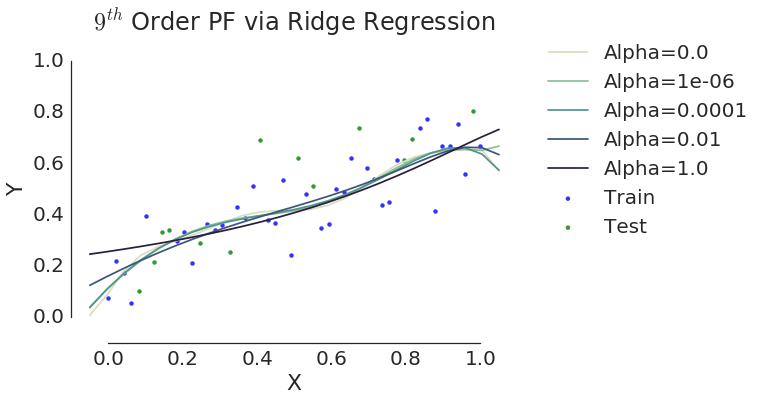

In [5]:
# Use Ridge Regression
from sklearn.linear_model import Ridge

#Show different alpha fits. Compare fit coeeficients.

alpha = [0.0, 1E-6, 1E-4, 1E-2, 1.0]

# Start plot
ax = sns.regplot(x_train, y_train, fit_reg=False, color='b', label="Train")
ax = sns.regplot(x_test, y_test, fit_reg=False, color='g', label="Test")
cmp = sns.cubehelix_palette(len(alpha), start=.5, rot=-.75)

print("Select Coefficients:\n")
print('alpha           x      x**2      x**3      x**4      x**5      x**6      x**7      x**8      x**9')
print('-------------------------------------------------------------------------------------------------')

for idx, al in enumerate(alpha):
    est = mp(PolynomialFeatures(9), Ridge(alpha=al))
    est.fit(x_train[:, np.newaxis], y_train)
    plt.plot(xf, est.predict(xf[:, np.newaxis]), c=cmp[idx], label='Alpha={0}'.format(al))
    cfs = est.steps[-1][1].coef_.ravel()
    
    print('{0:4.1e}'.format(al), end='')
    for val in cfs[1:]:
        print('{0:10.2f}'.format(val), end='')
    
    print()

ax.set(title='$9^{th}$ Order PF via Ridge Regression',
    xlabel='X', xlim=(-0.1, 1.1),
    ylabel='Y', ylim=(-0.1, 1.1))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #loc=4)
sns.despine(offset=0, trim=True)

-----

### Lasso Regularization

A second type of regularization is known as [Lasso regularization][lr],
short for least absolute shrinkage and selection operator, where an L1
norm is used as a penalty. In this case, only a subset of the original
model coefficients are selected while the remaining coefficients are set
to zero. This condition is enforced by requiring the sum of the absolute
values of the coefficients to be less than a fixed value. Thus the Lasso
technique leads to _sparse solutions_.

In scikit learn, the [`Lasso`][skl] class encodes this technique, and once
again the `alpha` parameter encodes the normalization condition.
Increasing the `alpha` parameter drives more coefficients to zero, such
that when `alpha = 1.0`, only one coefficient remains non-zero. In the
following example, we compute a Lasso regularization with Linear
regression for a high order polynomial function for different values of
`alpha`. As displayed in the following table and figure, as `alpha`
increases, the non-zero polynomial coefficients become progressively
fewer, reducing the chance of overfitting.

-----

[lr]: https://en.wikipedia.org/wiki/Lasso_(statistics)
[skl]: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

Select Coefficients:

alpha        x   x**2   x**3   x**4   x**5   x**6   x**7   x**8   x**9
----------------------------------------------------------------------
1.0e-06  1.272 -1.872  0.609  0.724  0.396  0.075 -0.114 -0.266 -0.309
1.0e-04  0.754 -0.469  0.000  0.101  0.342  0.000  0.000 -0.000 -0.216
1.0e-02  0.394  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
1.0e+00  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000


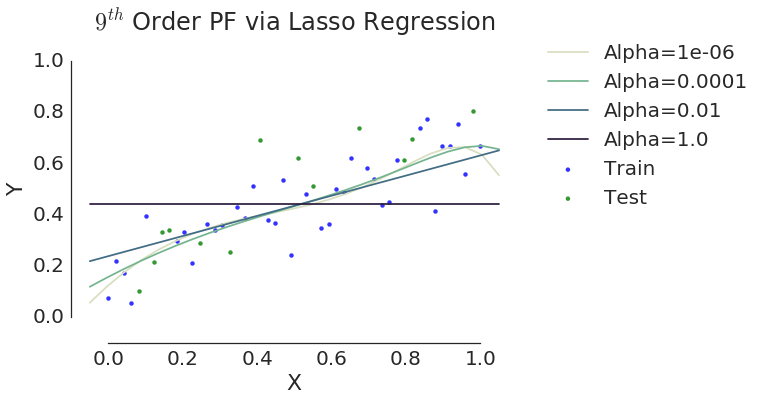

In [6]:
# Use Lasso
from sklearn.linear_model import Lasso

#Show different alpha fits. Compare fit coeeficients.

alpha = [1E-6, 1E-4, 1E-2, 1.0]

# Start plot
ax = sns.regplot(x_train, y_train, fit_reg=False, color='b', label="Train")
ax = sns.regplot(x_test, y_test, fit_reg=False, color='g', label="Test")
cmp = sns.cubehelix_palette(len(alpha), start=.5, rot=-.75)

print("Select Coefficients:\n")
print('alpha        x   x**2   x**3   x**4   x**5   x**6   x**7   x**8   x**9')
print('----------------------------------------------------------------------')

for idx, al in enumerate(alpha):
    est = mp(PolynomialFeatures(9), Lasso(alpha=al))
    est.fit(x_train[:, np.newaxis], y_train)
    plt.plot(xf, est.predict(xf[:, np.newaxis]), c=cmp[idx], label='Alpha={0}'.format(al))
    cfs = est.steps[-1][1].coef_.ravel()

    print('{0:4.1e}'.format(al), end='')
    for val in cfs[1:]:
        print('{0:7.3f}'.format(val), end='')
    
    print()

ax.set(title='$9^{th}$ Order PF via Lasso Regression',
    xlabel='X', xlim=(-0.1, 1.1),
    ylabel='Y', ylim=(-0.1, 1.1))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #loc=4)
sns.despine(offset=0, trim=True)

-----

### Elastic Net

In some cases, one might wish to employ both regularization techniques.
This approach is known as [Elastic Net][wen], which is implemented in
scikit learn by the [`ElasticNet`][ske] class. This class is typically
used with two parameters: `alpha` and `l1_ratio`. The `alpha` term is
what multiplies the normalization computation for both Ridge and Lasso
regularization. The `l1ratio` term specifies the relative mix between
the two techniques, with a value of 1 corresponding to pure _Lasso_, and
smaller values indicating a mixture.

In the following example, we demonstrate the use of `ElasticNet` by
employing the same example as before but in this case with a fixed
value for the `l1_ratio` term and allowing the `alpha` term to vary. As
before, increasing `alpha` leads to a more constrained model fit, as
shown in the fit coefficients, which become both progressively smaller and
increasingly more likely to be set to zero.

-----

[wen]: https://en.wikipedia.org/wiki/Elastic_net_regularization
[ske]: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet

Select Coefficients:

alpha        x   x**2   x**3   x**4   x**5   x**6   x**7   x**8   x**9
----------------------------------------------------------------------
1.0e-06  1.273 -1.874  0.610  0.724  0.399  0.079 -0.126 -0.263 -0.307
1.0e-04  0.867 -0.733 -0.000  0.311  0.395  0.002  0.000 -0.000 -0.332
1.0e-02  0.333  0.099  0.000  0.000  0.000  0.000  0.000  0.000  0.000
1.0e+00  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000


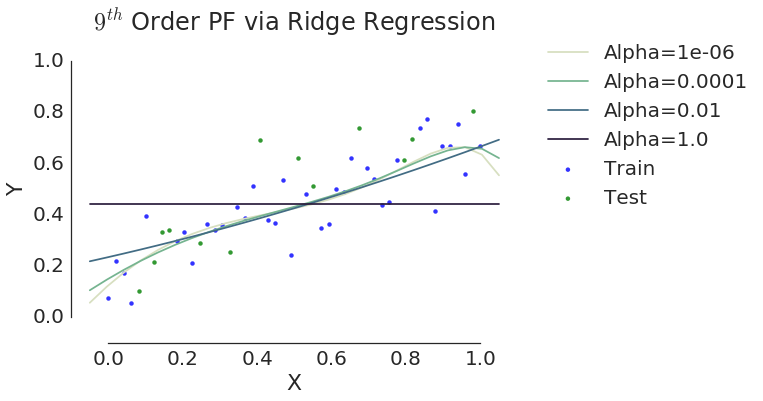

In [7]:
# Use Lasso
from sklearn.linear_model import ElasticNet

# Set L1/L2 ratio
l12_ratio = 0.5

#Show different alpha fits. Compare fit coeeficients.

alpha = [1E-6, 1E-4, 1E-2, 1.0]

# Start plot
ax = sns.regplot(x_train, y_train, fit_reg=False, color='b', label="Train")
ax = sns.regplot(x_test, y_test, fit_reg=False, color='g', label="Test")
cmp = sns.cubehelix_palette(len(alpha), start=.5, rot=-.75)

print("Select Coefficients:\n")
print('alpha        x   x**2   x**3   x**4   x**5   x**6   x**7   x**8   x**9')
print('----------------------------------------------------------------------')

for idx, al in enumerate(alpha):
    est = mp(PolynomialFeatures(9), ElasticNet(alpha=al, l1_ratio=l12_ratio))
    est.fit(x_train[:, np.newaxis], y_train)
    plt.plot(xf, est.predict(xf[:, np.newaxis]), c=cmp[idx], label='Alpha={0}'.format(al))
    cfs = est.steps[-1][1].coef_.ravel()

    print('{0:4.1e}'.format(al), end='')
    for val in cfs[1:]:
        print('{0:7.3f}'.format(val), end='')
    
    print()

ax.set(title='$9^{th}$ Order PF via Ridge Regression',
    xlabel='X', xlim=(-0.1, 1.1),
    ylabel='Y', ylim=(-0.1, 1.1))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #loc=4)
sns.despine(offset=0, trim=True)